# KNN regression
작성자 : 2DoLLars \
작성일 : 2021.11.04

KNN(K-nearest neighbour) 회귀모형은 사례기반(instance-based) 학습모형중 가장 흔히 사용되는 모형이다. 이 문서는 KNN 회귀모형을 이용한 함수추정을 수행을 다룬다.

## 모의데이터 생성
연속형 확률 변수 $Y$ 와 $X$ 에 대해 다음의 회귀모형을 가정하고, 회귀함수 $f$ 를 KNN 회귀모형을 이용하여 추정하려고 한다.

$$
Y = f(X) + \varepsilon = \sin (X^2) + \varepsilon \;,\;\varepsilon \sim N(0, 0.15^2) \\
X \sim \text{Uniform} (0, 1.5 \pi) \, , \; X \;, \varepsilon \; \text{are mutually independent}
$$

이제 위의 회귀모형으로부터 데이터 $\{(x_i, y_i)\}_{i=1}^{200}$ 를 생성하자.

Warning message:
"package 'FNN' was built under R version 3.6.3"

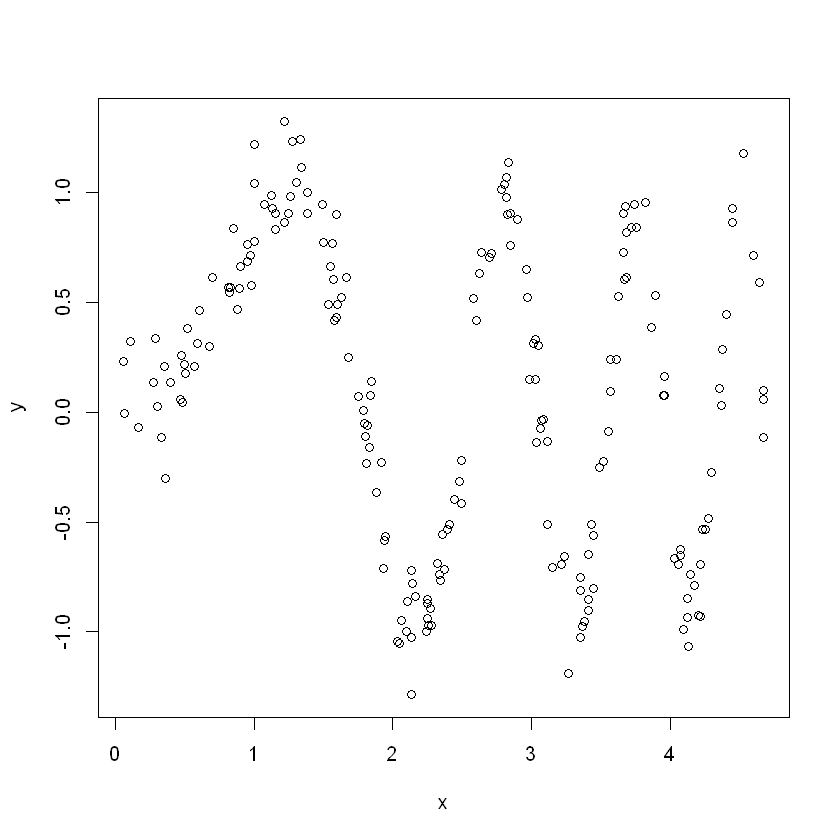

In [3]:
# install.packages("FNN")
library(FNN)
set.seed(1)
x = runif(200, 0, 1.5 * pi)
f = sin(x^2)
y = f + rnorm(200, 0, sd = 0.15)
plot(x, y)

R-패키지 FNN 의 내장함수 `knnx.index` 를 이용하여 $x = 3$ 에서 $K = 10$ 일때, 이웃(neighbour)를 구해보자.
(`knnx.index` 함수의 인자는 data, query, K 로 각각 이웃의 후보, 기준값, 이웃의 개수로 이해할 수 있다. 출력값으로 query 를 기준으로 $K$ 개 이웃에 해당하는 data 의 인덱스를 원소로 하는 행렬을 반환한다.)

In [4]:
K = 10
idx.mat = knnx.index(x, 3, K)
print(idx.mat)

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]  105  120   93  134  171    9  177   42   65    23


데이터의 산점도에 앞서 구한 이웃을 빨간 점으로 표시해보자. 그리고 $x = 3$ 에서 KNN 회귀값(regression value)을 예측하고 이를 수평선으로 표현한다.

[1] 0.2172316


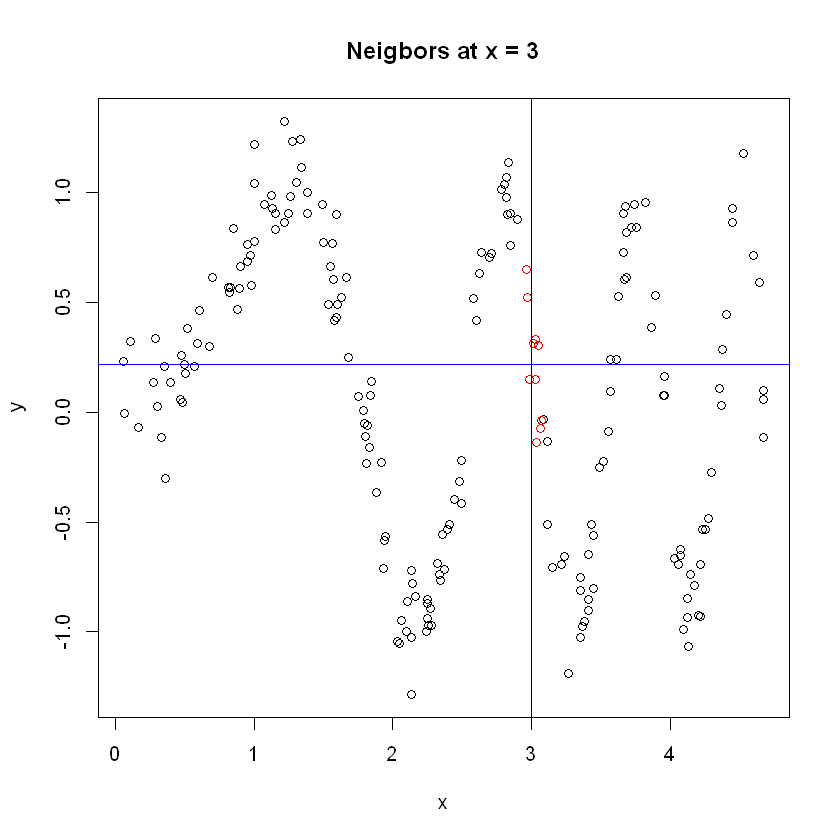

In [5]:
plot(x, y, main = "Neigbors at x = 3")
points(x[idx.mat[1, ]], y[idx.mat[1, ]], col = "red")
yhat = mean(y[idx.mat[1, ]])
print(yhat)
abline(v = 3, col = "black")
abline(h = yhat, col = "blue")

이제, 함수 $f$ 에 대한 KNN 추정치를 좀 더 명확하게 정의해보자.

$
\{ x_1 , \ldots , x_n \} \; : \text{the values of predictor}
\\
N_K(x) = \{\text{The index of} \ x_i's \ \text{close to the x}\}
\\
$

$$
\text{The KNN estimate for} \; f(x_i) :
\\
\hat{f}(x_i) = \frac{1}{K} \sum_{j \in N_K(x_i)} y_j 
$$

$$
\text{The KNN estimate for} \; f :
\\
\hat{f} : [0, \; 1.5 \pi] \longrightarrow \mathbb{R} \quad \text{by} \;
\\
\hat{f}(x) = \frac{1}{K} \sum_{j \in N_K(x)} y_j  \quad , \; x \in [0, \; 1.5\pi]
$$

즉, 함수 $f$ 에 대한 KNN 추정치를 표현하기 위해서는 $[0, \; 1.5 \pi]$ 상의 모든 점에 대해 $\hat{f}(x)$ 을 구하여 그려야한다.

이제, 함수 `knnx.index` 을 이용하여 $K = 5$ 일때 $f$ 에 대한 KKN 추정치를 구하고 데이터 산점도 위에 그려보자.

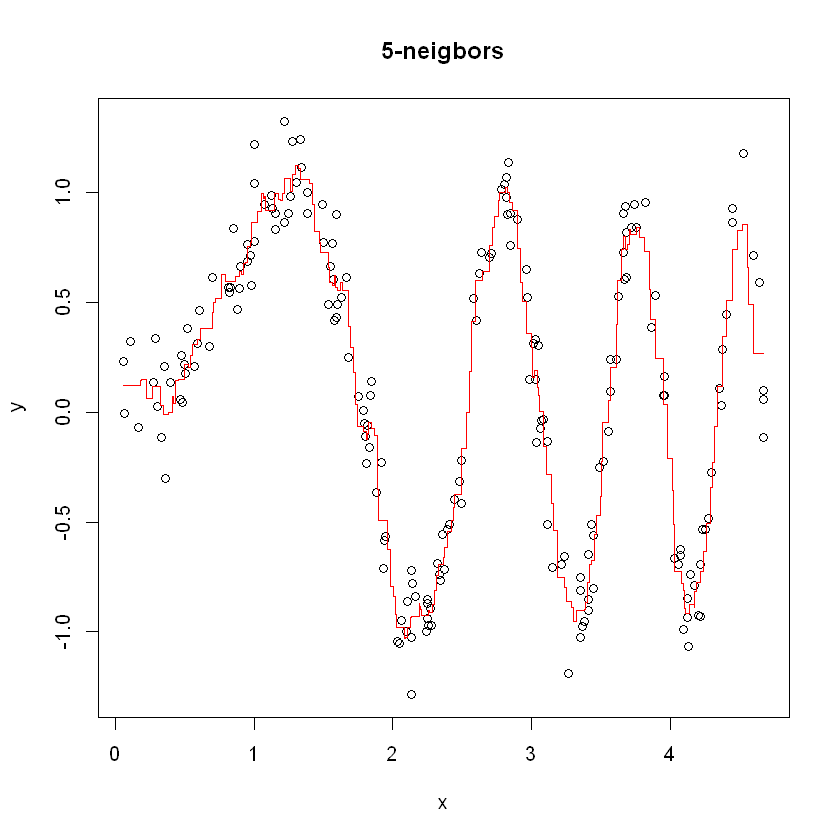

In [6]:
x.grid = seq(min(x), max(x), length.out = 1000) # f 에 대한 knn 추정치를 그리기 위한 그리드

K = 5
idx.mat = knnx.index(x, x.grid, K)
# 그리드에 각각 대한 이웃을 구한 행렬. idx.mat[1, ] 는 1번째 그리드에 대한 이웃을 나타낸다.
yhat = rep(NA, length(x.grid))

for (i in 1:length(x.grid)) yhat[i] = mean(y[idx.mat[i , ]]) # 각 그리드에 대한 knn 추정값 생성

plot(x, y, main = paste0(K, "-neigbors"))
lines(x.grid, yhat, lty = 1, col = "red", type = "s")

$K = 1, 5, 10, 30, 100, 200$ 일때 $f$ 에 대한 KKN 추정치를 구해보자. 아래의 그림으로 부터 $K$ 가 KNN 추정량의 복잡도(complexity)와 관계가 있음을 알 수 있다.

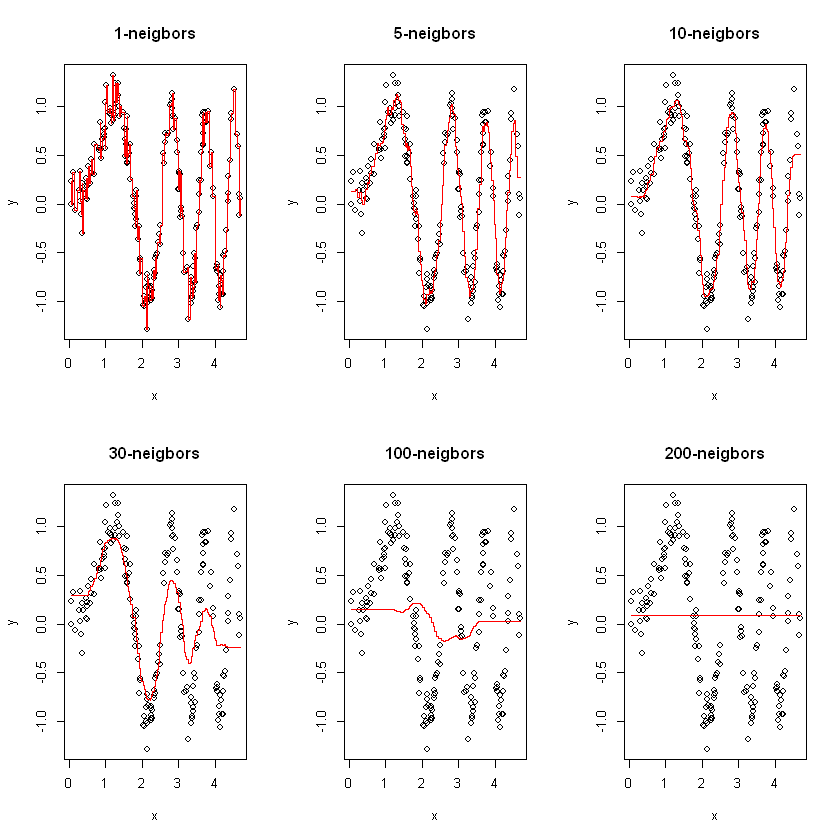

In [7]:
par(mfrow = c(2, 3))
for (K in c(1, 5, 10, 30, 100, 200)) # 이웃의 개수 = 1, 5, 10, 30, 100, 200 에 대해 반복
{
   idx.mat = knnx.index(x, x.grid, K)
   yhat = rep(0, length(x.grid))
   
   for (i in 1:length(x.grid)) yhat[i] = mean(y[idx.mat[i , ]])
   
   plot(x, y, main = paste0(K, "-neigbors"))
   lines(x.grid, yhat, lty = 1, col = "red", type = "s")
}

$K = 1, 2, \ldots, 40$ 에 대하여 10-겹(fold) 교차검증(cross validation)을 수행하여 최적의 K 를 구해보자.

In [17]:
# 10-fold cross validation
k = 10 

# Randomly shuffle the data
shuffle_idx = sample(1 : 200, size = 200, replace = FALSE)

x = x[shuffle_idx]
y = y[shuffle_idx]

folds = cut(1 : 200, breaks = k, labels = FALSE)

[1] "optimal K : 4"


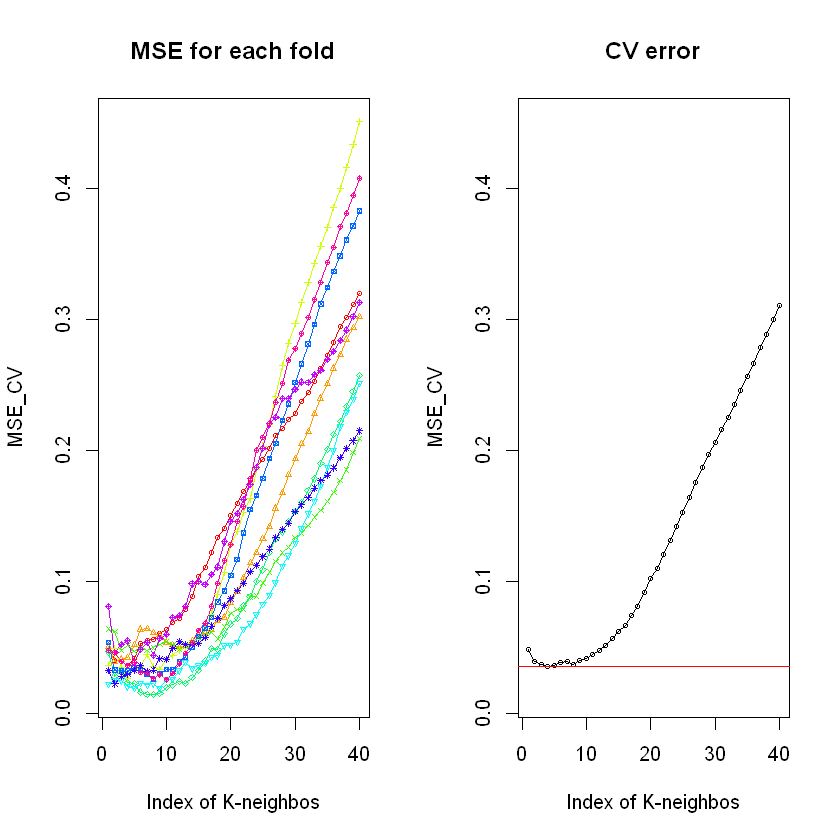

In [27]:
set.seed(1)

MSE_cv_matrix = matrix(NA, nrow = 10, ncol = 40) # 교차검증에서 구한 MSE 를 저장하기 위핸 행렬

for(fold in 1 : 10) # 각 폴드에 대한 반복문
{
   # 폴드 인덱스를 이용하여 훈련자료와 검증자료로 나눔
   train_x = x[!(folds == fold)]
   train_y = y[!(folds == fold)]
   validation_x = x[folds == fold]
   validation_y = y[folds == fold]
      
   for(K in 1 : 40) # 이웃의 개수 1 - 40 에 대해 반복
   {
      idx.mat = knnx.index(train_x, validation_x, K)
      yhat = rep(0, length(validation_y))
      
      for (i in 1 : length(validation_x)) yhat[i] = mean(train_y[idx.mat[i, ]])
      
      MSE_cv_matrix[fold, K] = mean((validation_y - yhat)^2)
   }
}

par(mfrow = c(1, 2))
plot(MSE_cv_matrix[1, ], col = "white", ylim = c(min(MSE_cv_matrix), max(MSE_cv_matrix)),
     xlab = "Index of K-neighbos", ylab = "MSE_CV", main = "MSE for each fold")
cols = rainbow(10)

for (i in 1 : 10) lines(MSE_cv_matrix[i, ], col = cols[i])
for (i in 1 : 10) points(1 : 40, MSE_cv_matrix[i,], col = cols[i], pch = i, cex = 0.5)

cv_error = colMeans(MSE_cv_matrix)
plot(cv_error, col = "white", ylim = c(min(MSE_cv_matrix), max(MSE_cv_matrix)),
     xlab = "Index of K-neighbos", ylab = "MSE_CV", main = "CV error")
lines(cv_error, col = "black")
points(1 : 40, cv_error, col = "black", pch = 1, cex = 0.5)
abline(h = min(cv_error), col = "red")


print(paste0("optimal K : ", which.min(cv_error)))

10-겹 교차검증결과 최적의 $K$ 는 $4$ 로 주어졌다. $K=4$ 에 대해 최적의 KNN 추정치를 구해보자.

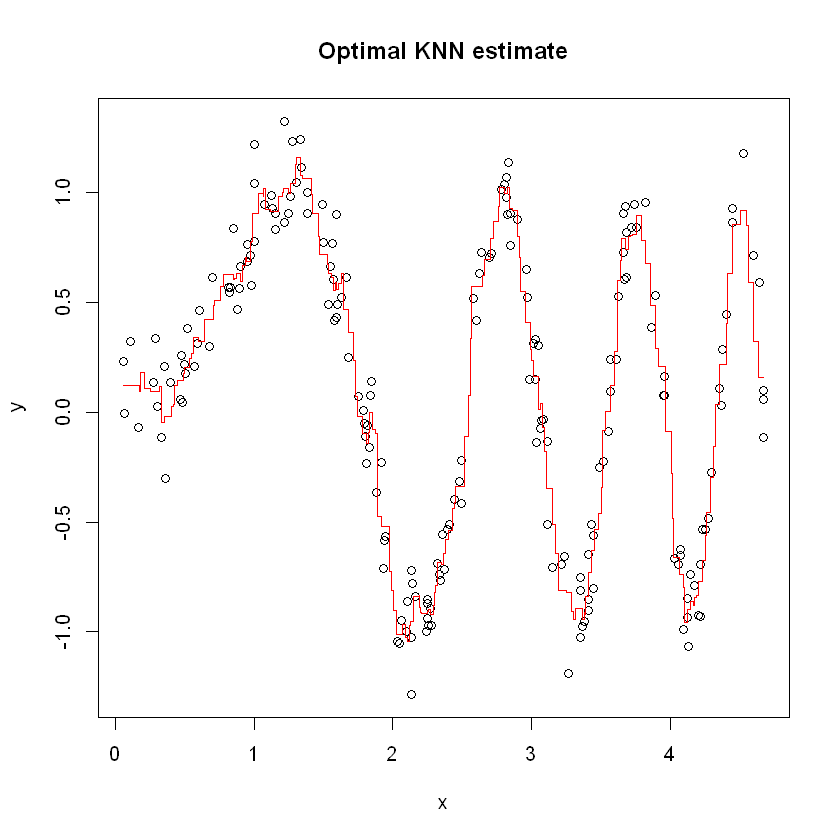

In [28]:
idx.mat = knnx.index(x, x.grid, which.min(cv_error))
yhat = rep(0, length(x.grid))
   
for (i in 1:length(x.grid)) yhat[i] = mean(y[idx.mat[i , ]])
   
plot(x, y, main = "Optimal KNN estimate")
lines(x.grid, yhat, lty = 1, col = "red", type = "s")